In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
plt.rcParams['mathtext.fontset'] = 'stix'

from sgoopT import stationary, mu_factor, eigenval, sg_transmat, sgap
from cmap1dT import SgoopDistance
import scipy.optimize as opt

# Variables

In [2]:
# data:
filename={}
s={}
weights={}
mids={}
prob={}
freeE={}

# MD parameters:
beta=2.5
Rout=100  # (unit: steps/lines)

# metaD parameters:
stride={}
wbias={}
delta_beta={}

# SGOOP parameters:
rc_bin={}
wells={}
th={}
coeff={}
rc={}
pi={}
MU={}
S={}
E={}
binedges={}

# First SGOOP

### Read trajectory files

In [3]:
# Read unbiased data:
filename['unbiased']='./DATA_aladip/unbiased_T300/COLVAR'
s['unbiased'] = np.loadtxt(filename['unbiased'], unpack=True, usecols=(4,5,6,7,8,9), skiprows=7, max_rows=50000)

# Read biased data:
filename['biased_1']='./DATA_aladip/biased1_T300/COLVAR'
s['1']=np.loadtxt(filename['biased_1'], unpack=True, usecols=(4,5,6,7,8,9), skiprows=7)

### Read reweighting factors

In [4]:
filename['weights']='./DATA_aladip/biased1_T300/weights_aladip_biased1.txt'
weights['1']=np.loadtxt(filename['weights'])

### Spectral gap optimization: Find optimal RC $\chi^{(1)}$

In [ ]:
def compute_sgap(coeff_i, rc_bin_i=20, wells_i=2, weights_i=None):
    # function to be used in basinhopping. records function evaluations and returns -spectral gap
    global nfev
    nfev +=1
    rc['unbiased']=np.dot(coeff_i, s['unbiased'][:,:50000])
    rc['i'] = np.dot(coeff_i, s['1'])
    
    pi['i'], binedges['i'] = stationary(rc['i'], rc_bin=rc_bin_i, weights=weights['1'])
    MU['i'] = mu_factor(rc['unbiased'], pi['i'], binedges['i'], max_d=1)
    S['i'] = sg_transmat(rc_bin_i, pi['i'], MU['i'], max_d=1)
    
    return sgap(S['i'], wells_i)

def print_fun(x, f, accepted):
    global now,last,nfev,lastf
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev

start = time.time()

coeff['1']=np.array([0.02, 0.97, -0.25, -0.02, 0.5, 0.5])
rc_bin['1']=50
wells['1']=3

def opti_func(coeff_i):
    return -compute_sgap(coeff_i, rc_bin_i=rc_bin['1'], wells_i=wells['1'])

last = start
lastf = nfev = 0
minimizer_kwargs = {"options": {"maxiter":10}}
ret = opt.basinhopping(opti_func, coeff['1'], niter=50, T=.01, stepsize=.1, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
end = time.time()
print(end-start)
ret

### Exp(eigenvalues) and 0th eigenvectors of MaxCal-based rate matrix for optimal RC $\chi^{(1)}$

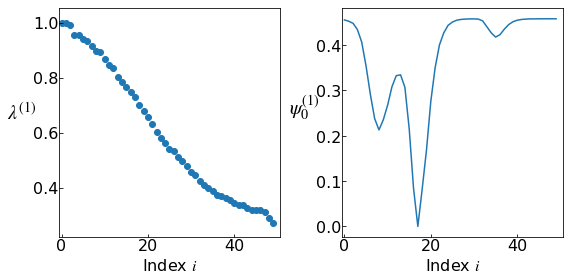

In [5]:
# parameters:
rc_bin['1']=50

# Optimal coefficients of linear combination computed from the previous step
coeff['1']=np.array([0.64325837,  0.778393  , -0.13339705, -0.08794336, -0.22147228, -0.16453171])

# data:
rc['unbiased'] = np.dot(coeff['1'], s['unbiased'][:,:50000])
rc['1'] = np.dot(coeff['1'], s['1'])
pi['1'], binedges['1'] = stationary(rc['1'], rc_bin=rc_bin['1'], weights=weights['1'])
MU['1'] = mu_factor(rc['unbiased'], pi['1'], binedges['1'], max_d=1)
S['1'] = sg_transmat(rc_bin['1'], pi['1'], MU['1'], max_d=1)
E['1'] = eigenval(S['1'])
eval1, exp_eval1, evec1 = E['1']
rate1 = -eval1

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ax[0].scatter(list(range(len(E['1'][1]))), E['1'][1])
ax[1].plot(E['1'][2][:,0]-np.min(E['1'][2][:,0]))

ax[0].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[0].set_xlabel('Index $i$', size=16)
ax[0].set_ylabel('$\lambda^{(1)}$', size=20).set_rotation(0)
ax[0].yaxis.set_label_coords(-0.17, 0.5)
ax[0].set_xlim(-0.5, rc_bin['1']+0.5)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[1].set_xlabel('Index $i$', size=16)
ax[1].set_ylabel('$\psi^{(1)}_0$', size=20).set_rotation(0)
ax[1].yaxis.set_label_coords(-0.17, 0.5)
ax[1].set_xlim(-0.5, rc_bin['1']+0.5)

fig.tight_layout()
plt.show()

# Second SGOOP

In [6]:
# Read biased data:
filename['biased_2']='./DATA_aladip/biased2_T300/COLVAR'
s['2']=np.loadtxt(filename['biased_2'], unpack=True, usecols=(4,5,6,7,8,9), skiprows=7)

### Spectral gap optimization: Find optimal RC $\chi^{(2)}$

In [ ]:
def compute_sgap(coeff_i, rc_bin_i=20, wells_i=2, weights_i=None):
    # function to be used in basinhopping. records function evaluations and returns -spectral gap
    global nfev
    nfev +=1
    rc['unbiased']=np.dot(coeff_i, s['2'][:,50000:200000])
    rc['i'] = np.dot(coeff_i, s['2'])
    
    pi['i'], binedges['i'] = stationary(rc['i'], rc_bin=rc_bin_i)
    MU['i'] = mu_factor(rc['unbiased'], pi['i'], binedges['i'], max_d=1)
    S['i'] = sg_transmat(rc_bin_i, pi['i'], MU['i'], max_d=1)
    
    return sgap(S['i'], wells_i)

def print_fun(x, f, accepted):
    global now,last,nfev,lastf
    now=time.time()
    print(x,end=' ')
    if accepted == 1:
        print("with spectral gap %.4f accepted after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    else:
        print("with spectral gap %.4f declined after %3i runs (%.3f)" % (-f, nfev-lastf, now-last))
    last=now
    lastf=nfev

start = time.time()

coeff['2']=np.array([0.2, 0.5, -0.25, -0.2, -0.5, 0.5])
rc_bin['2']=50
wells['2']=3

def opti_func(coeff_i):
    return -compute_sgap(coeff_i, rc_bin_i=rc_bin['2'], wells_i=wells['2'])

last = start
lastf = nfev = 0
minimizer_kwargs = {"options": {"maxiter":10}}
ret = opt.basinhopping(opti_func, coeff['1'], niter=100, T=.01, stepsize=.1, minimizer_kwargs=minimizer_kwargs, callback=print_fun)
end = time.time()
print(end-start)
ret

### Exp(eigenvalues) and 0th eigenvectors of MaxCal-based rate matrix for optimal RC $\chi^{(2)}$

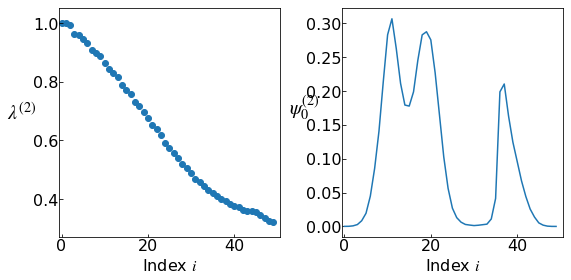

In [7]:
# parameters:
rc_bin['2']=50
# Optimal coefficients of linear combination computed from the previous step
coeff['2']=np.array([0.82665355,  1.16592255, -0.11967506,  0.57802668,  0.01336444, 0.24045454])

# data:
rc['unbiased'] = np.dot(coeff['2'], s['2'][:,50000:200000])
rc['2'] = np.dot(coeff['2'], s['2'])
pi['2'], binedges['2'] = stationary(rc['2'], rc_bin=rc_bin['2'])
MU['2'] = mu_factor(rc['unbiased'], pi['2'], binedges['2'], max_d=1)
S['2'] = sg_transmat(rc_bin['2'], pi['2'], MU['2'], max_d=1)
E['2'] = eigenval(S['2'])
eval2, exp_eval2, evec2 = E['2']
rate2 = -eval2

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ax[0].scatter(list(range(len(E['2'][1]))), E['2'][1])
ax[1].plot(E['2'][2][:,0]-np.min(E['2'][2][:,0]))

ax[0].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[0].set_xlabel('Index $i$', size=16)
ax[0].set_ylabel('$\lambda^{(2)}$', size=20).set_rotation(0)
ax[0].yaxis.set_label_coords(-0.17, 0.5)
ax[0].set_xlim(-0.5, rc_bin['2']+0.5)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[1].set_xlabel('Index $i$', size=16)
ax[1].set_ylabel('$\psi^{(2)}_0$', size=20).set_rotation(0)
ax[1].yaxis.set_label_coords(-0.17, 0.5)
ax[1].set_xlim(-0.5, rc_bin['2']+0.5)

fig.tight_layout()
plt.show()

# SGOOP-d

In [8]:
sgd1 = SgoopDistance(coeff['1'], eval1, evec1, binedges['1'])
sgd2 = SgoopDistance(coeff['2'], eval2, evec2, binedges['2'])

def rate1xd(pos1, pos2, K=1, num_eig=rc_bin['1']):
    """
    Calculate rate1 * d_comm.
    """
    d_comm1 = sgd1.pairwise_d(pos1, pos2, num_eig)
    d_comm2 = sgd2.pairwise_d(pos1, pos2, num_eig)
    
    d_hat1 = rate1[1]*d_comm1
    d_hat2 = rate2[1]*d_comm2
    
    return d_hat1 + K*d_hat2

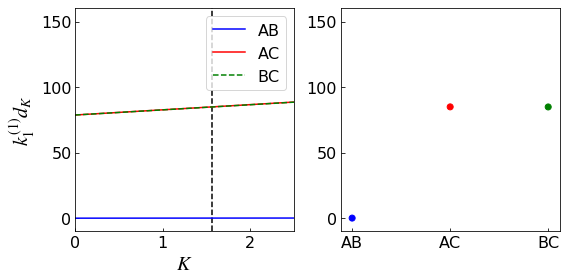

In [9]:
C7eq1=(-2.8, 2.9, 0.3)
C7eq2=(-1.25, 1.0, 0.3)
C7ax=(1.2, -0.8, 0.3)

A=( np.cos(C7eq1[0]), np.sin(C7eq1[0]), np.cos(C7eq1[1]), np.sin(C7eq1[1]), np.cos(C7eq1[2]), np.sin(C7eq1[2]) )
B=( np.cos(C7eq2[0]), np.sin(C7eq2[0]), np.cos(C7eq2[1]), np.sin(C7eq2[1]), np.cos(C7eq2[2]), np.sin(C7eq2[2]) )
C=( np.cos(C7ax[0]), np.sin(C7ax[0]), np.cos(C7ax[1]), np.sin(C7ax[1]), np.cos(C7ax[2]), np.sin(C7ax[2]) )

K_ast=rate1[1]/rate2[1]

kd=np.array([rate1xd(A,B, K_ast), rate1xd(A,C, K_ast), rate1xd(B,C, K_ast)])

# Plottings:
K_arr=np.arange(0,200,1)
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)
ax[0].plot([K_ast]*3, np.linspace(-10,800,3), 'k--')
ax[0].plot(K_arr, rate1xd(A,B,K_arr), 'b-', label='AB')
ax[0].plot(K_arr, rate1xd(A,C,K_arr), 'r-', label='AC')
ax[0].plot(K_arr, rate1xd(B,C,K_arr), 'g--', label='BC')

ax[1].scatter(np.arange(kd.shape[0]), kd, c=['b', 'r', 'g'])

ax[0].tick_params(axis='both', which='major', direction='in', labelsize=16)
ax[0].set_xlabel('$K$', size=20)
ax[0].set_ylabel('$k^{(1)}_1 d_K$', size=20)
ax[0].set_xlim(0,2.5)
ax[0].set_ylim(-10,160)
ax[0].legend(loc='upper right', fontsize=16)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16)
ax[1].set_xticks([0, 1, 2])
labels = [item.get_text() for item in ax[1].get_xticklabels()]
ax[1].set_xticklabels(['AB', 'AC', 'BC'])
ax[1].set_ylim(-10,160)

fig.tight_layout()
plt.show()